# Predicting Student Admissions with Neural Networks
In this notebook, we predict student admissions to graduate school at UCLA based on three pieces of data:

    -GRE Scores (Test)
    -GPA Scores (Grades)
    -Class rank (1-4)

The dataset originally came from here: http://www.ats.ucla.edu/

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading the data

In [2]:
data = pd.read_csv('student_data.csv')
data.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## Plotting the data

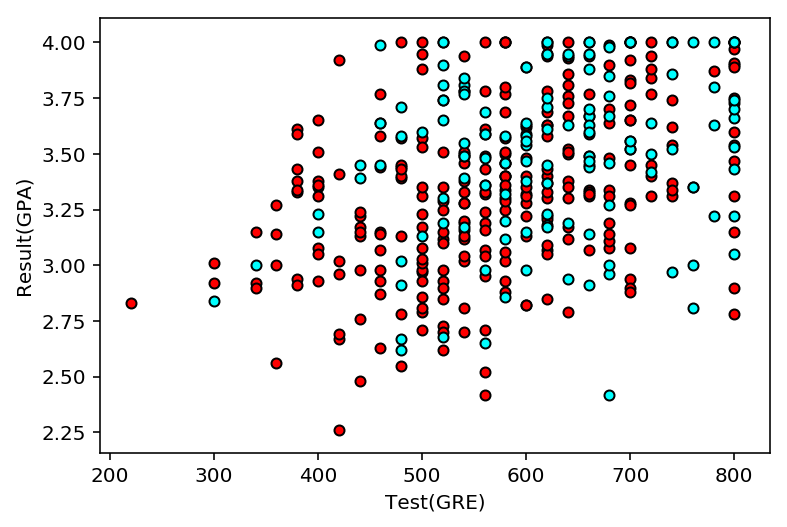

In [3]:
def plot_points(data):
    X = np.array(data[['gre', 'gpa']])
    y = np.array(data['admit'])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s=25, color='red', edgecolors='k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s=25, color='cyan', edgecolors='k')
    plt.xlabel('Test(GRE)')
    plt.ylabel('Result(GPA)')

plot_points(data)
plt.show()

Roughly, it looks like the students with high scores in the grades and test passed, while the ones with low scores didn't, but the data is not as nicely separable as we hoped it would. Maybe it would help to take the rank into account? Let's make 4 plots, each one for each rank.

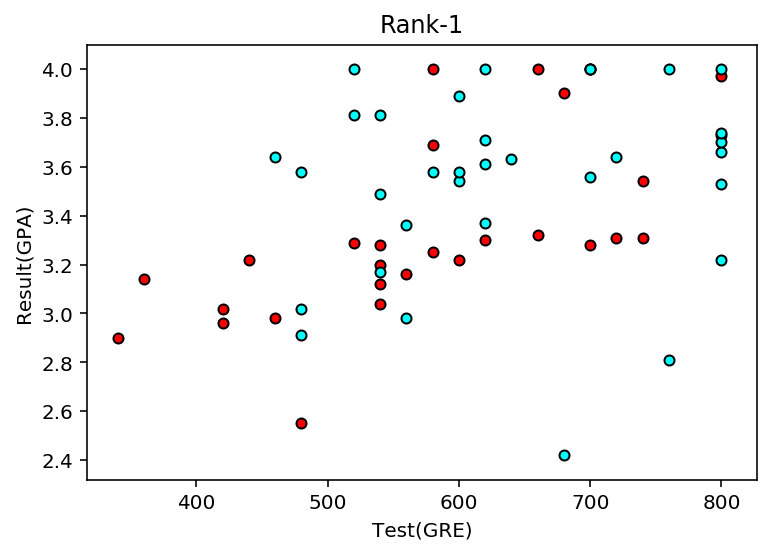

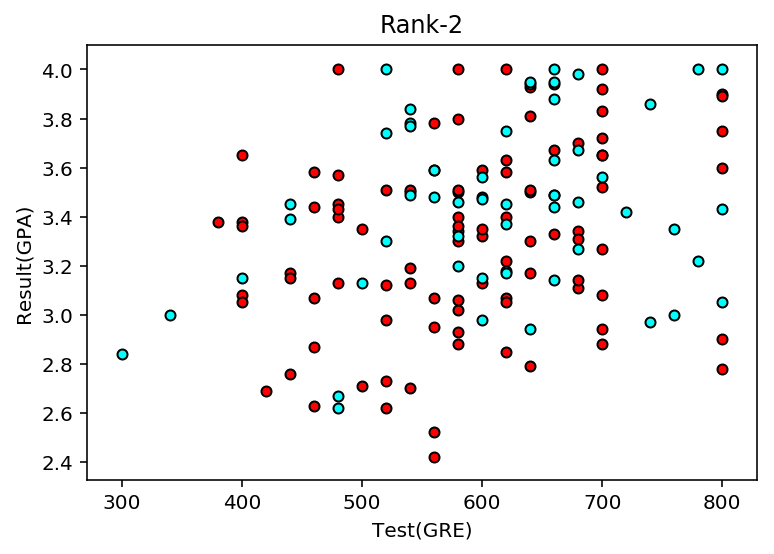

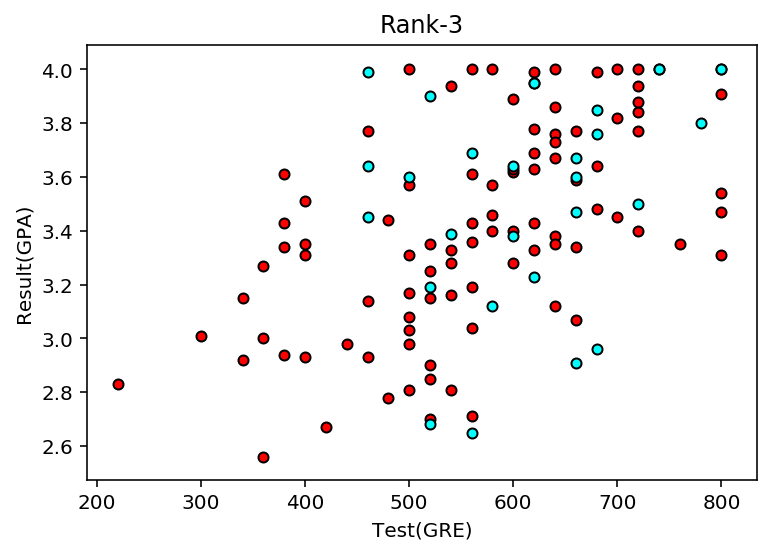

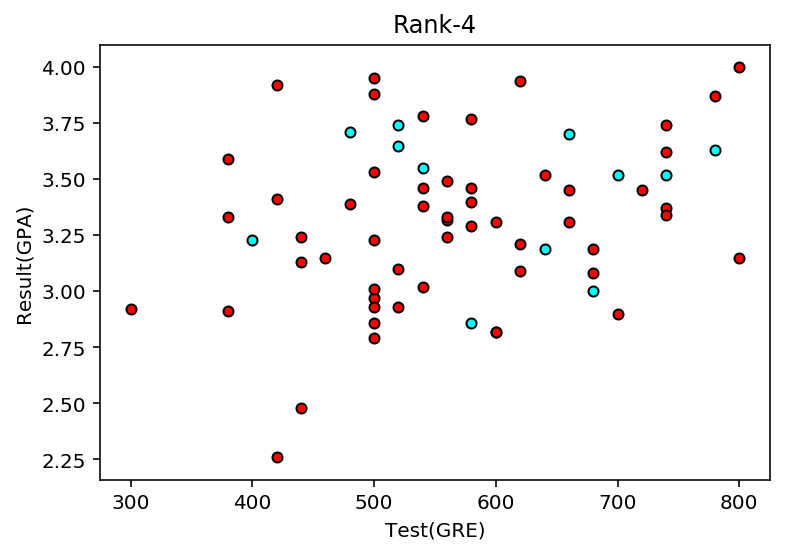

In [4]:
# data_rank list of dataframes 
data_rank = [data[data['rank'] == x] for x in np.sort(data['rank'].unique())]

# plotting
for x in data_rank:
    plot_points(x)
    plt.title('Rank-' + str(x['rank'].unique()[0]))
    plt.show()

This looks more promising, as it seems that the lower the rank, the higher the acceptance rate. Let's use the rank as one of our inputs. In order to do this, we should one-hot encode it.

## One-hot encode the rank

In [5]:
# General function to apply one-hot encode on any data, just pass the dataset and col to convert to one-hot encoded vector
def one_hot_encoder(dataset, col):
    classes = np.sort(dataset[col].unique())
    one_hot_vector = np.array([[0  if val != c else 1 for c in classes] for val in dataset[col]])
    dataset = pd.merge(
        dataset,
        pd.DataFrame(data=one_hot_vector, columns=classes),
        left_index=True, 
        right_index=True
    )
    dataset.drop([col], axis=1, inplace=True)
    return dataset

one_hot_data = one_hot_encoder(data, 'rank')

In [6]:
one_hot_data.head()

,admit,gre,gpa,1,2,3,4
0,0,380,3.61,0,0,1,0
1,1,660,3.67,0,0,1,0
2,1,800,4.00,1,0,0,0
3,1,640,3.19,0,0,0,1
4,0,520,2.93,0,0,0,1


## Scaling the data

The next step is to scale the data. We notice that the range for grades is 1.0-4.0, whereas the range for test scores is roughly 200-800, which is much larger. This means our data is skewed, and that makes it hard for a neural network to handle. Let's fit our two features into a range of 0-1, by dividing the grades by 4.0, and the test score by 800.

In [7]:
def scale_data(dataset, *cols):
    for col in cols:
        dataset[col] = dataset[col]/np.max(dataset[col])
    return dataset

processed_data = scale_data(one_hot_data, ['gre', 'gpa'])

In [8]:
processed_data.head()

,admit,gre,gpa,1,2,3,4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0
3,1,0.800,0.7975,0,0,0,1
4,0,0.650,0.7325,0,0,0,1


## Splitting the data into training and testing proceeding with splitting the data into features(X) and  lables(y)

Let train_data = (x)% of the total data, and testing data = (100-x)%

As we want random values from dataset to be selected as sample, we will use np.random.choice() to select random indices for sample

In [28]:
def train_test_split(data):
    # >>>processed_data.index
    # RangeIndex(start=0, stop=400, step=1)
    sample = np.random.choice(data.index, size=int(len(data)*0.8), replace=False)
    train_data, test_data = data.iloc[sample], data.drop(sample)
    print('No. of training data: ', len(train_data))
    print('No. of testing data: ', len(test_data))
    return train_data, test_data
    
def feature_label_split(data, label_col):
    train_data, test_data = train_test_split(data)
    return train_data.drop([label_col], axis=1), train_data[label_col], test_data.drop([label_col], axis=1), test_data[label_col]

features, labels, features_test, labels_test = feature_label_split(processed_data, 'admit')

No. of training data:  320
No. of testing data:  80


In [29]:
features

,gre,gpa,1,2,3,4
1,0.825,0.9175,0,0,1,0
91,0.900,0.9100,1,0,0,0
149,0.925,0.8275,1,0,0,0
157,0.600,0.8950,1,0,0,0
368,0.725,1.0000,1,0,0,0
136,0.700,0.8325,0,0,0,1
151,0.500,0.8450,0,1,0,0
72,0.600,0.8475,0,0,0,1
365,0.600,0.6950,0,0,1,0
304,0.275,0.7075,0,0,1,0
